In [21]:
import pandas as pd
import simple_icd_10_cm as cm

In [22]:
# Load dataset

from tdc.multi_pred import TrialOutcome
data = TrialOutcome(name = 'phase1') # 'phase2' / 'phase3'
split = data.get_split()

Found local copy...
Loading...
Done!


In [23]:
template = """### Instructions: Answer the following question about clinical trials.
### Context: Clinical trial is the most time and cost-consuming step in the drug discovery process. Phase 1 clinical trials test the safety and basic properties of a new 
drug or treatment in a small group of people for the first time. Optimizing and designing trials with machine learning could drastically lead to the speedup of delivery 
of life-saving therapeutics to patients. Clinical trial outcome prediction is a machine learning task that aims to forecast the outcome of clinical trials, such as the 
approval rate of a drug or treatment. It utilizes various clinical trial features, including the drug’s molecular structure and patient disease.
### Question: Given a drug SMILES string and disease, predict if the phase 1 trial
(A) would not be approved (B) would be approved 
Drug SMILES: {}
Disease: {} 
### Answer: {}"""


In [24]:
split["train"].head()

,nctid,start_date,complete_date,drug_molecules,icdcodes,eligibility_criteria,Y
0,NCT00002790,March 1996,NaN,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\\C=C\\C...,D89.810__D89.811__D89.813__D89.812__C95.91__C9...,DISEASE CHARACTERISTICS: See General Eligibili...,0
1,NCT00002863,June 1996,July 2000,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,C96.A__C46.9__C96.22__C46.0__C46.2__C92.31__C9...,DISEASE CHARACTERISTICS: Biopsy-proven soft ti...,0
2,NCT00003005,December 1997,March 2001,[H][C@@]1(CO)C[C@@]([H])(O)[C@@]([H])(O1)N1C=N...,C95.91__C95.92__Z80.6__Z85.6__C90.11__C90.12__...,DISEASE CHARACTERISTICS: TdT positive acute ly...,0
3,NCT00003060,March 1995,"February 22, 2001",CS(=O)(=O)OCCCCOS(C)(=O)=O__ClCCN(CCCl)P1(=O)N...,C43.51__C43.9__C43.52__D03.51__C43.8__Z85.820_...,DISEASE CHARACTERISTICS: Biopsy proven relapse...,0
4,NCT00003194,July 1997,"December 19, 2002",N[C@@H](CCCNC(N)=N)C(O)=O__ClCCN(CCCl)P1(=O)NC...,H01.009__H02.209__H02.009__H02.109__H04.209__H...,DISEASE CHARACTERISTICS: - Histologically prov...,0


In [25]:
def icd_string(x):
    icd_codes = []
    for i in x:
        try:
            icd_codes.append(
                cm.get_description(i)
            )
        except ValueError:
            pass
    
    try:
        return icd_codes[0]
    except IndexError:
        return ""
    
        
    

split["train"]["icdcodes_str"] = split["train"]["icdcodes"].str.split("__").apply(icd_string)
split["valid"]["icdcodes_str"] = split["valid"]["icdcodes"].str.split("__").apply(icd_string)
split["test"]["icdcodes_str"] = split["test"]["icdcodes"].str.split("__").apply(icd_string)

In [26]:
split["train"] = split["train"].loc[split["train"]["icdcodes_str"].str.len()>0]
split["valid"] = split["valid"].loc[split["valid"]["icdcodes_str"].str.len()>0]
split["test"] = split["test"].loc[split["test"]["icdcodes_str"].str.len()>0]

In [27]:
# process dataset

def formatting_prompts_func(examples):
    drug_molecules = examples["drug_molecules"]
    icdcodes_str = examples["icdcodes_str"]
    outputs       = examples["Y"]
    texts = []
    for p,m,o in zip(drug_molecules, icdcodes_str, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "(B)" if o else "(A)")
        texts.append(text)
    return { "text" : texts, "drug_molecules":drug_molecules, "icdcodes_str":icdcodes_str, "outputs":outputs, "ds_ident":"TrialOutcome_phase1"}

def formatting_prompts_func_test(examples):
    drug_molecules = examples["drug_molecules"]
    icdcodes_str = examples["icdcodes_str"]
    outputs       = examples["Y"]
    texts = []
    for p,m,o in zip(drug_molecules, icdcodes_str, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "")
        texts.append(text)
    return { "text" : texts, "drug_molecules":drug_molecules, "icdcodes_str":icdcodes_str, "outputs":outputs, "ds_ident":"TrialOutcome_phase1"}


In [28]:
train_dataset = formatting_prompts_func(split["train"])
valid_dataset = formatting_prompts_func_test(split["valid"])
test_dataset = formatting_prompts_func_test(split["test"])

<Axes: >

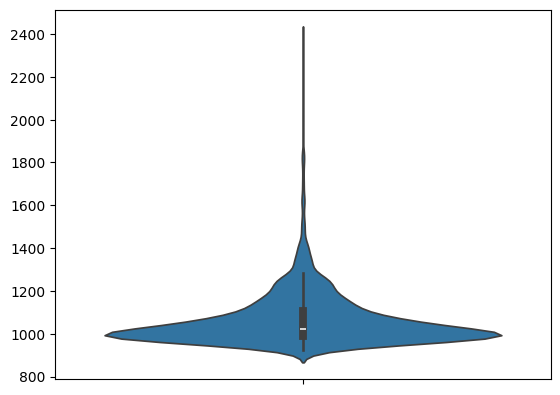

In [29]:
import seaborn as sns
sns.violinplot(list(map(len,train_dataset["text"])))

In [30]:
len(train_dataset["text"]), len(valid_dataset["text"]), len(test_dataset["text"])

(1678, 240, 480)

In [31]:
def filter_data(ds):
    ds = pd.DataFrame.from_dict(ds)
    ds = ds.loc[(ds["icdcodes_str"].str.len()>0)&(ds["text"].str.len()<1800)]
    return ds.to_dict(orient="list")

In [32]:
train_dataset = filter_data(train_dataset)
valid_dataset = filter_data(valid_dataset)
test_dataset = filter_data(test_dataset)

<Axes: >

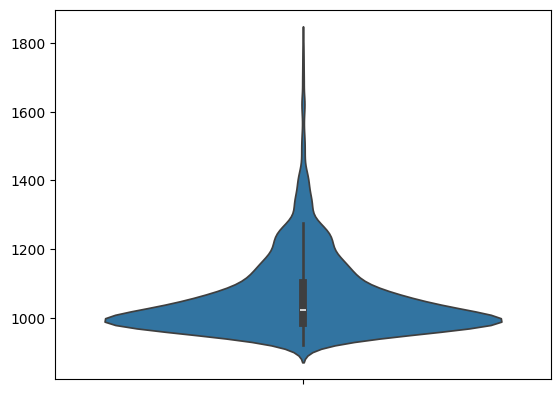

In [33]:
import seaborn as sns
sns.violinplot(list(map(len,train_dataset["text"])))

In [34]:
import pickle
import os


def dump_file(obj, path, file_name):
    os.makedirs(path, exist_ok=True)
    file_name = os.path.join(path,file_name)
    with open(file_name, "wb") as f0:
        pickle.dump(obj,f0)

In [35]:
dump_file(train_dataset, "processed", "train.pkl")
dump_file(valid_dataset, "processed", "valid.pkl")
dump_file(test_dataset, "processed", "test.pkl")